In [1]:
from sklearn.mixture import GaussianMixture
from hough_circle_trafo import hough_circle
from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import ndimage
from background_subtraction_gmm import Backsub as Backsub
from sklearn.cluster import KMeans
from cluster_half_shelfs_alpha import Half_shelf_cluster
import scienceplots
import cv2 as cv
from matplotlib import cm
from segmentation import Segmentation as Segmentation
from PIL import Image, ImageDraw
import networkx as nx
from networkx.algorithms import bipartite
from scipy.stats import norm
from scipy.signal import savgol_filter
np.random.seed(137)

In [2]:
start_frame=0
end_frame=987
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
obj_0=np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
obj_0=obj_0[1:,:]
r_effective=11


In [3]:
koppenrath=Confectionery()
blue_vector=np.array([0,0,255],dtype=np.uint8).reshape((1,1,3))
green_vector=np.array([0,128,0],dtype=np.uint8).reshape((1,1,3))
cyan_vector=np.array([0,255,255],dtype=np.uint8).reshape((1,1,3))
red_vector=np.array([255,0,0]).reshape((1,1,3))



# time space mean, then cluster

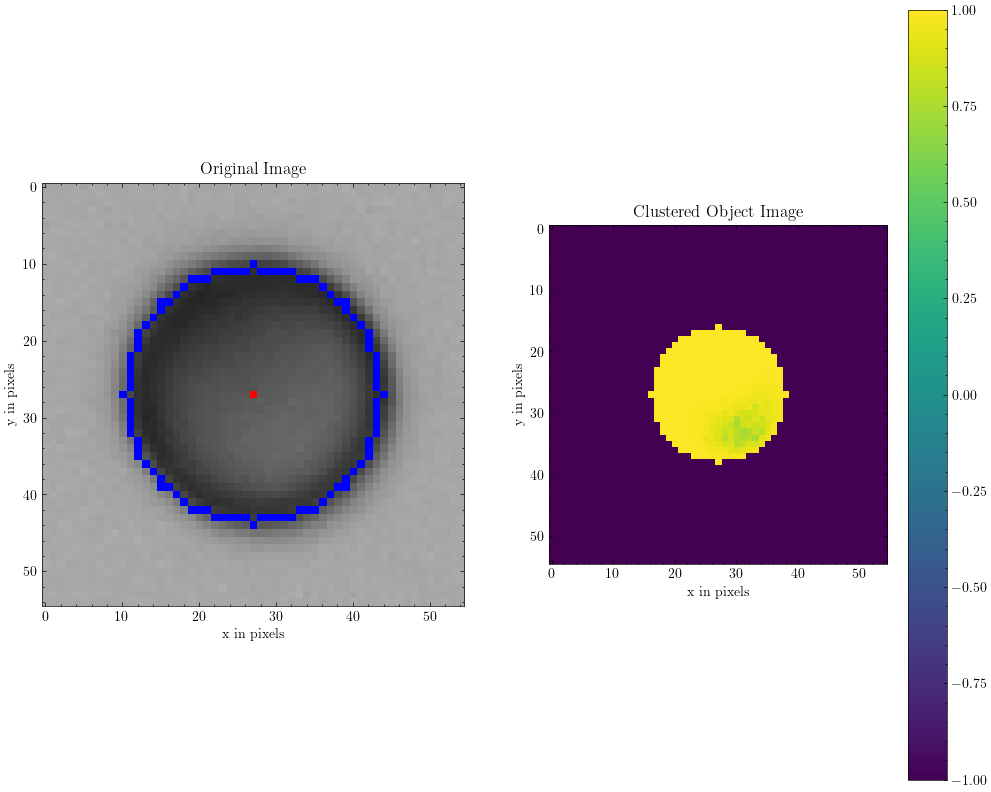

In [4]:
frame_number=98
cluster=Half_shelf_cluster(obj_0, stream_string, confectionery=koppenrath,cut_radius=r_effective)
cluster.load_data_from_np_array(np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0_all_grayscale_on_radius_11.npy"))
cluster.train_gmm()
gmm=cluster.gmm

frame_numbers=np.arange(frame_number-1,frame_number+2)
ims=[cv.imread(cv.samples.findFile(stream_string[f]), cv.IMREAD_GRAYSCALE) for f in frame_numbers]
obj=obj_0[frame_number,1:]
X=obj_0[frame_numbers,1]
Y=obj_0[frame_numbers,2]
r=np.mean(obj_0[frame_numbers,-1])
a=10
object_indeces=[np.s_[-a+round(y-round(r)):round(y+round(r))+1+a,
                     -a+round(x-round(r)):round(x+round(r))+1+a] for x,y in zip(X,Y)]
im_objs=[a[b] for a,b in zip(ims,object_indeces)]
im_objs=np.array(im_objs)

M=[koppenrath.sell_cake(r_effective,a.shape[0],a.shape[1]) for a in im_objs]
M=np.array(M)


time_series=np.array([a[b==1] for a,b in zip(im_objs,M)]).astype(np.float32)
time_series_mean=np.mean(time_series,axis=0)

im_obj=im_objs[1]
matrix_mean=np.copy(M[1]).astype(np.uint8)
matrix_mean[M[1]==1]=time_series_mean
matrix_mean[M[1]==0]=im_obj[M[1]==0]

prob=gmm.predict_proba(time_series_mean.reshape((-1,1)))
prob=prob[:,cluster.gmm_idx]
im_clustered=-np.ones(im_obj.shape,np.float32)
im_clustered[M[1]==1]=prob[:,0]

im_bgr=cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR)
center=((im_bgr.shape[0]-1)//2, (im_bgr.shape[0]-1)//2)
im_bgr[center[0],center[0],:]=np.array([255,0,0])
cv.circle(im_bgr, center, round(r), (0,0,255), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Original Image")
    ax1.imshow(im_bgr,cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image')
    a=ax2.imshow(im_clustered,cmap="viridis",vmin=-1,vmax=1)
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    fig.colorbar(a, ax=ax2,location='right')
    plt.show()

In [5]:
r_effective=11
frame_number=np.arange(50)
r_max=np.max(obj_0[frame_number,-1])
r_min=int(np.floor(np.min(obj_0[frame_number,-1])))
r_min=r_effective
im=[cv.imread(cv.samples.findFile(stream_string[f]), cv.IMREAD_GRAYSCALE) for f in frame_number]
obj=obj_0[frame_number,1:]
X=obj[:,0]
Y=obj[:,1]
a=10

object_indeces=[np.s_[-a+round(y-round(r_max)):round(y+round(r_max))+1+a,
                     -a+round(x-round(r_max)):round(x+round(r_max))+1+a] for x,y in zip(X,Y)]
im_obj=[cv.GaussianBlur(im[i][s],ksize=(3,3), sigmaX=0) for i,s in enumerate(object_indeces)]
M=[koppenrath.sell_cake(r_min,s.shape[0],s.shape[1]) for s in im_obj]
time_series=[x[m==1] for x,m in zip(im_obj,M)]
time_series=np.array(time_series).astype(np.float64)


# apply savgol filter derivative

In [6]:
dev=savgol_filter(time_series, window_length=5, polyorder=4, deriv=1, axis=1)


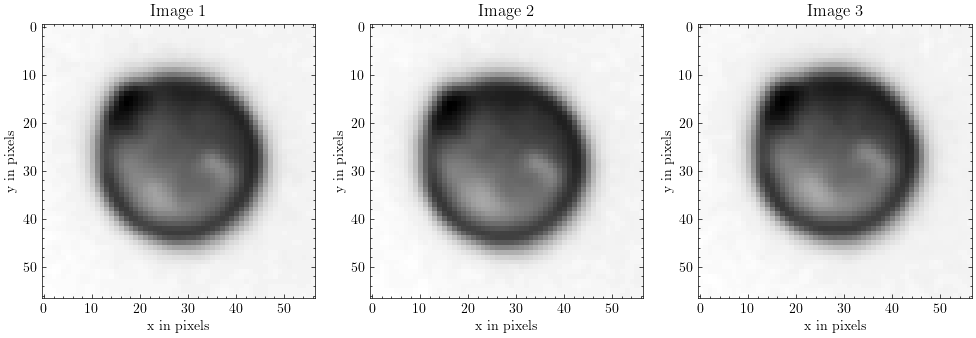

In [7]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.set_title("Image 1")
    ax1.imshow(im_obj[0],cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Image 2')
    ax2.imshow(im_obj[1],cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    ax3.set_title('Image 3')
    ax3.imshow(im_obj[2],cmap="gray")
    ax3.set_xlabel("x in pixels")
    ax3.set_ylabel("y in pixels")
    plt.show()

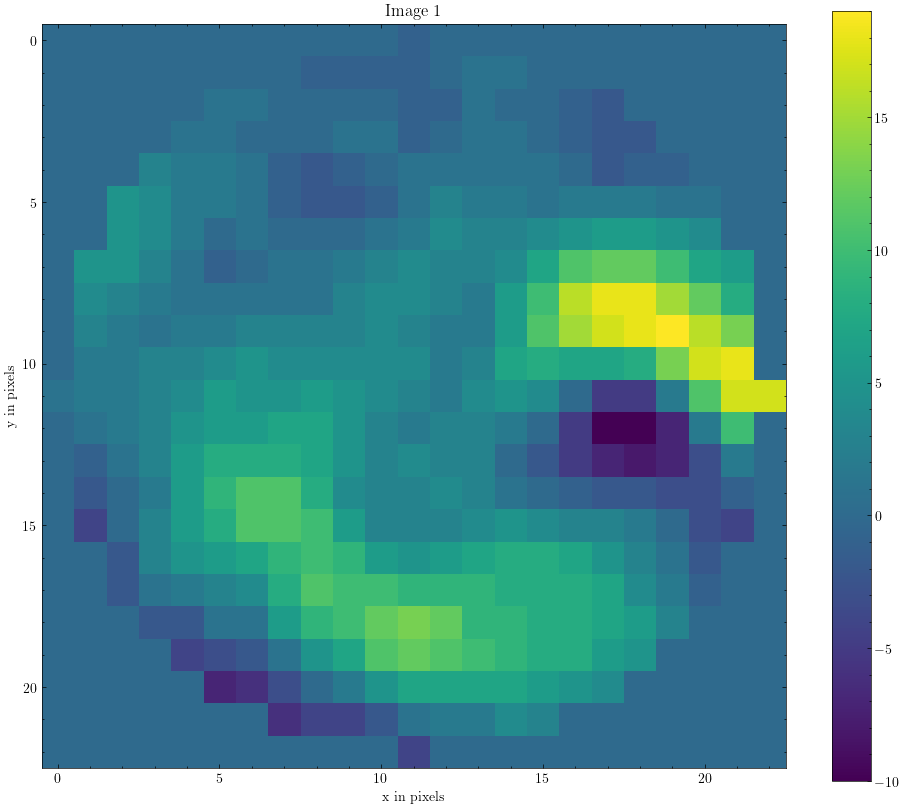

In [8]:
M_effective=koppenrath.sell_cake(radius=r_min,width=2*r_min+1,height=2*r_min+1)
I_dt=np.zeros(M_effective.shape,np.float32)
im_obj=[a.astype(np.float32) for a in im_obj]
I_dt[M_effective]=im_obj[2][M[2]==1]-im_obj[0][M[0]==1]
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title("Image 1")
    a=ax1.imshow(I_dt)
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    plt.colorbar(a)
    plt.show()


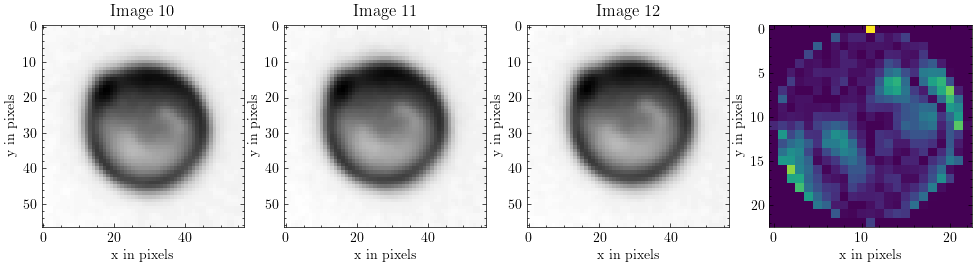

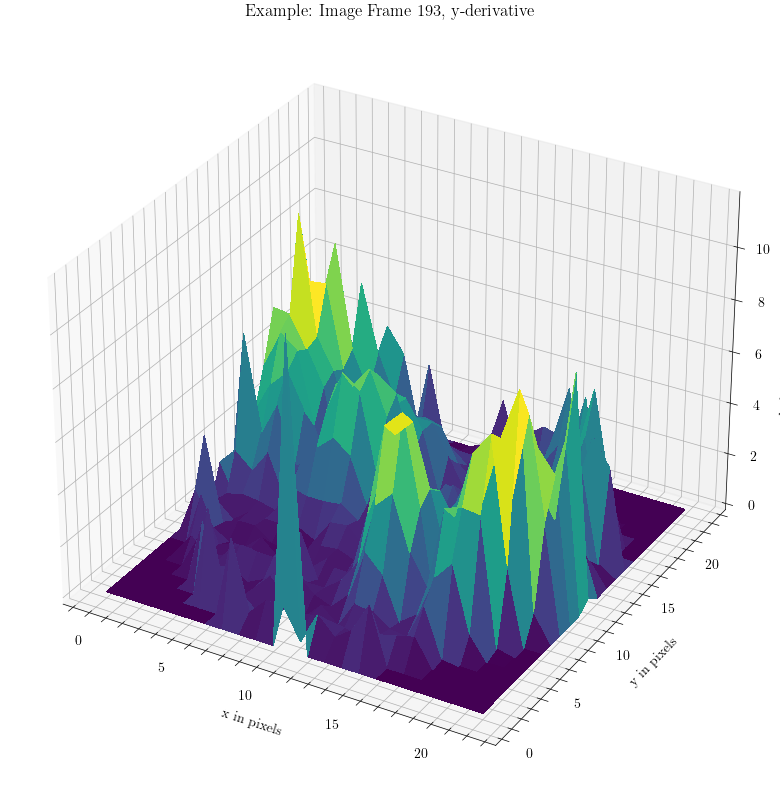

In [9]:
M_effective=koppenrath.sell_cake(radius=r_min,width=2*r_min+1,height=2*r_min+1)
I_dt=np.zeros(M_effective.shape,np.float32)
I_dt[M_effective]=dev[11,:]
I_dt=np.abs(I_dt)
%matplotlib ipympl

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    ax1.set_title("Image 10")
    ax1.imshow(im_obj[10],cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Image 11')
    ax2.imshow(im_obj[11],cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    ax3.set_title('Image 12')
    ax3.imshow(im_obj[12],cmap="gray")
    ax3.set_xlabel("x in pixels")
    ax3.set_ylabel("y in pixels")
    ax4.imshow(I_dt)
    ax4.set_xlabel("x in pixels")
    ax4.set_ylabel("y in pixels")
    plt.show()

X=np.arange(I_dt.shape[0])
X,Y=np.meshgrid(X,X)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plt.title("Example: Image Frame 193, y-derivative")
    # Plot the surface.
    surf = ax.plot_surface(X, Y, I_dt, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    ax.set_zlabel("y-derivative (dimensionless)")
    plt.show()